In [1]:
import os
if 'DISPLAY' in os.environ:
    del os.environ['DISPLAY']
import torch
import dill
import os.path as op
import numpy as np
import hnn_core
from hnn_core import simulate_dipole, Network, read_params, JoblibBackend
import matplotlib as mpl
import matplotlib.pyplot as plt
import sbi.utils as utils
from sbi.inference.base import infer
import multiprocessing
import datetime
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from scipy import interpolate
import glob
import pandas as pd

import sys
sys.path.append('../')
import spike_train_functions
import hnn_simnets_functions
import numba
import sbi_functions
from sbi_functions import run_simulator
from joblib import Parallel, delayed
import umap
import umap.plot
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")


/home/ntolley/anaconda3/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


In [2]:
save_name ='beta_event_basket_ampa_t100000_02222021_131840'
data_path = '/home/ntolley/Jones_Lab/sbi_hnn/data/beta/prerun_simulations/' + save_name + '/'

prior_dict_file = open(data_path + 'prior_dict_' + save_name + '.pkl', 'rb')
prior_dict = dill.load(prior_dict_file)
prior_dict_file.close()

prior_file = open(data_path + 'prior_' + save_name + '.pkl', 'rb')
prior = dill.load(prior_file)   
prior_file.close()

params_fname_file = open(data_path + 'params_fname_' + save_name + '.pkl', 'rb')
params_fname = dill.load(params_fname_file)
params_fname_file.close()
# params_fname = '../../data/beta/params/beta_param.param'

dpl_files = sorted(glob.glob(data_path + 'data/*dpl*sim*'))
theta_files = sorted(glob.glob(data_path + 'data/*theta*sim*'))
# spike_gids_files = sorted(glob.glob(data_path + 'data/spike_gids*'))
# spike_times_files = sorted(glob.glob(data_path + 'data/spike_times*'))
# spike_types_files = sorted(glob.glob(data_path + 'data/spike_types*'))

In [3]:
dpl_preprocessed_file = open(data_path + 'dpl_preprocessed_100x_downsample.pkl', 'rb')
dpl_preprocessed = dill.load(dpl_preprocessed_file)
dpl_preprocessed_file.close()
dpl, theta, sim_times = dpl_preprocessed['dpl'], dpl_preprocessed['theta'], dpl_preprocessed['sim_times']

#Load patient data
beta23 = np.loadtxt('../../data/beta/aging_grant/S1_23.txt')
beta43 = np.loadtxt('../../data/beta/aging_grant/S10_43.txt')

#convert time to ms
beta23[:,0] = beta23[:,0] * 1e3
beta43[:,0] = beta43[:,0] * 1e3

#Interpolate patient EEG to match simulation timepoints
offset = 50 #shift patient data to better align with simulations
real_tstart, real_t_end, num_pts = sim_times[0] + offset, sim_times[-1] + offset, len(sim_times) 
real_times = sim_times.copy() + offset
# real_times = np.linspace(real_tstart,real_t_end,num_pts)

beta23_interp_func = interpolate.interp1d(beta23[:,0], beta23[:,1], kind='cubic')
beta23_dpl = beta23_interp_func(real_times)

beta43_interp_func = interpolate.interp1d(beta43[:,0], beta43[:,1], kind='cubic')
beta43_dpl = beta43_interp_func(real_times)

#Apply dipole scaling
scaling = 5
beta23_dpl, beta43_dpl = beta23_dpl*scaling, beta43_dpl*scaling





(-100, 100)

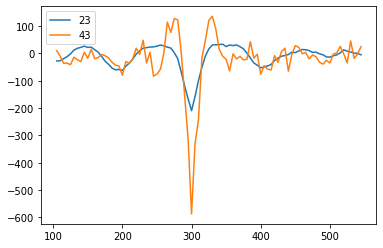

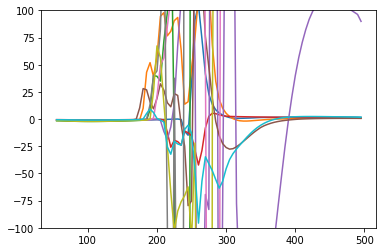

In [4]:
plt.figure()
plt.plot(real_times, beta23_dpl)
plt.plot(real_times, beta43_dpl)
plt.legend(['23', '43'])

plt.figure()
idx = 1
plt.plot(sim_times, np.array(dpl)[idx:idx+10,:].transpose())
plt.ylim([-100,100])

In [5]:
# embedding_net = sbi_functions.model_ann(input_size=dpl.shape[1], output_size=10, layer_size=[200,50])

# neural_posterior = utils.posterior_nn(model='maf', embedding_net=embedding_net)
# inference = SNPE(prior=prior)
# inference = inference.append_simulations(torch.as_tensor(theta).float(), torch.as_tensor(dpl).float())
# density_estimator = inference.train(show_train_summary=True)
# posterior = inference.build_posterior(density_estimator)

In [6]:
#___Save posterior___
# posterior_files = {
#     'posterior': posterior,
#     'sim_times': sim_times,
#     'real_tstart': real_tstart,
#     'real_t_end': real_t_end,
#     'dpl_preprocessed': dpl_preprocessed
#     }

# save_file = open(data_path + 'posterior_files_ANN_embedding.pkl', 'wb')
# dill.dump(posterior_files, save_file)
# save_file.close()

In [7]:
# ___Load posterior___
posterior_file = open(data_path + 'posterior_files_ANN_embedding.pkl', 'rb')
posterior = dill.load(posterior_file)
posterior_file.close()
locals().update(posterior)

In [8]:
num_samples = 8

posterior.set_default_x(beta23_dpl)
theta_samples_beta23 = posterior.sample((num_samples,))
posterior.set_default_x(beta43_dpl)
theta_samples_beta43 = posterior.sample((num_samples,))

    


In [9]:
res_beta23 = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_beta23[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))
res_beta43 = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_beta43[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))

# save_file = open('/mnt/d/Jones_Lab/snpe/res_beta23.pkl', 'wb')
# dill.dump(res_beta23, save_file)
# save_file.close()

# save_file = open('/mnt/d/Jones_Lab/snpe/res_beta43.pkl', 'wb')
# dill.dump(res_beta43, save_file)
# save_file.close()




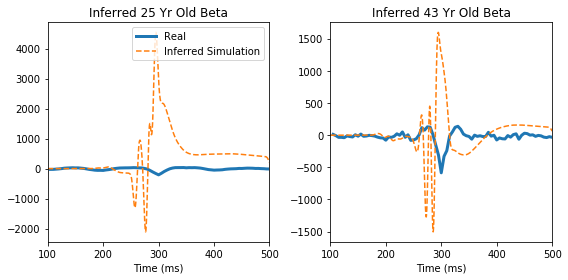

In [12]:
plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.plot(real_times, beta23_dpl, 'C0', LineWidth=3)
#6, 13
plt.plot(np.linspace(0,500,10001), res_beta23[1][0], 'C1', LineStyle='--', alpha=1)
plt.legend(['Real', 'Inferred Simulation'])
plt.title('Inferred 25 Yr Old Beta')
plt.xlim([100,500])
# plt.ylim([-850,550])
plt.xlabel('Time (ms)')

plt.subplot(1,2,2)
plt.plot(real_times, beta43_dpl, 'C0',LineWidth=3)
#2, 13
plt.plot(np.linspace(0,500,10001), res_beta43[2][0], 'C1', LineStyle='--', alpha=1)
plt.title('Inferred 43 Yr Old Beta')
plt.xlim([100,500])
plt.xlabel('Time (ms)')
# plt.ylim([-850,550])
plt.tight_layout()
# plt.savefig('/mnt/d/Jones_Lab/snpe/inferred_beta_v2.eps', format='eps')



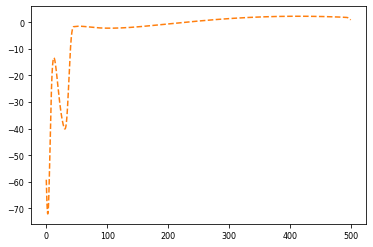

In [28]:
plt.plot(np.linspace(0,500,10001), res_beta23[3][0], 'C1', LineStyle='--', alpha=1)


In [7]:
param_names = ['dipole scale fctr', 'prox. time', 'prox. variance', '# prox. spikes', 'prox. g_ampa L2/3 PN', 'prox. g_ampa L5 PN', 'prox. g_ampa L2/3 Bsk', 'prox. g_ampa L5 Bsk', 'dist. time', 'dist. variance', '# dist. spikes', 'dist. g_ampa L2/3 PN', 'dist. g_ampa L5 PN', 'dist. g_ampa L2/3 Bsk', 'dist. g_ampa L5 Bsk']
limits = [item for key, item in prior_dict.items()]
# subset = [1,2,3,4,5]
subset = list(range(len(param_names)))
plt.rc('axes', labelsize=10)   
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels

In [8]:
# samples = posterior.sample((1000,), x=beta23_dpl)
# _ = utils.pairplot(samples, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)

In [9]:
# samples = posterior.sample((1000,), x=beta43_dpl)
# _ = utils.pairplot(samples, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)

Condition on 23 yr old dipole

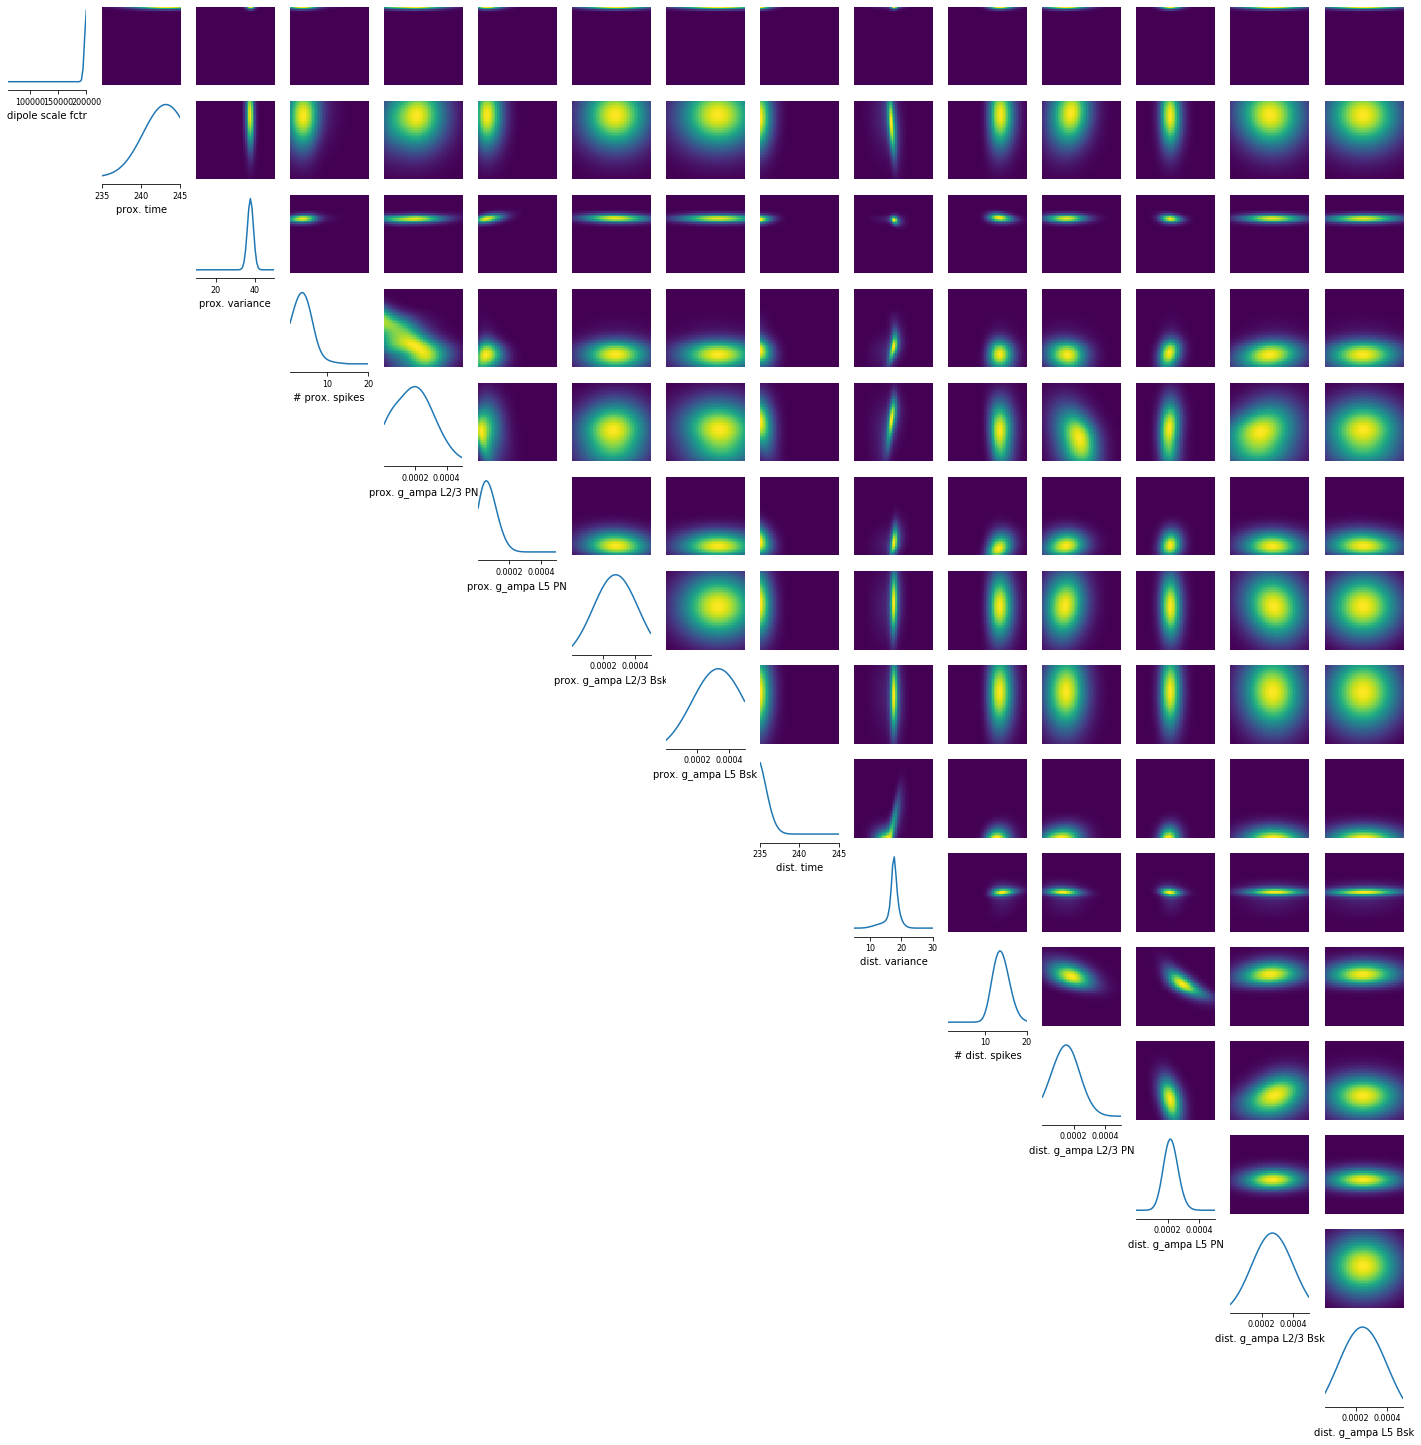

In [10]:
condition = posterior.sample((1,), x=beta23_dpl)
posterior.set_default_x(beta23_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(25,25), labels=param_names, limits=limits, subset=subset)
#plt.savefig('/mnt/d/Jones_Lab/snpe/beta25_scale5.eps', format='eps')

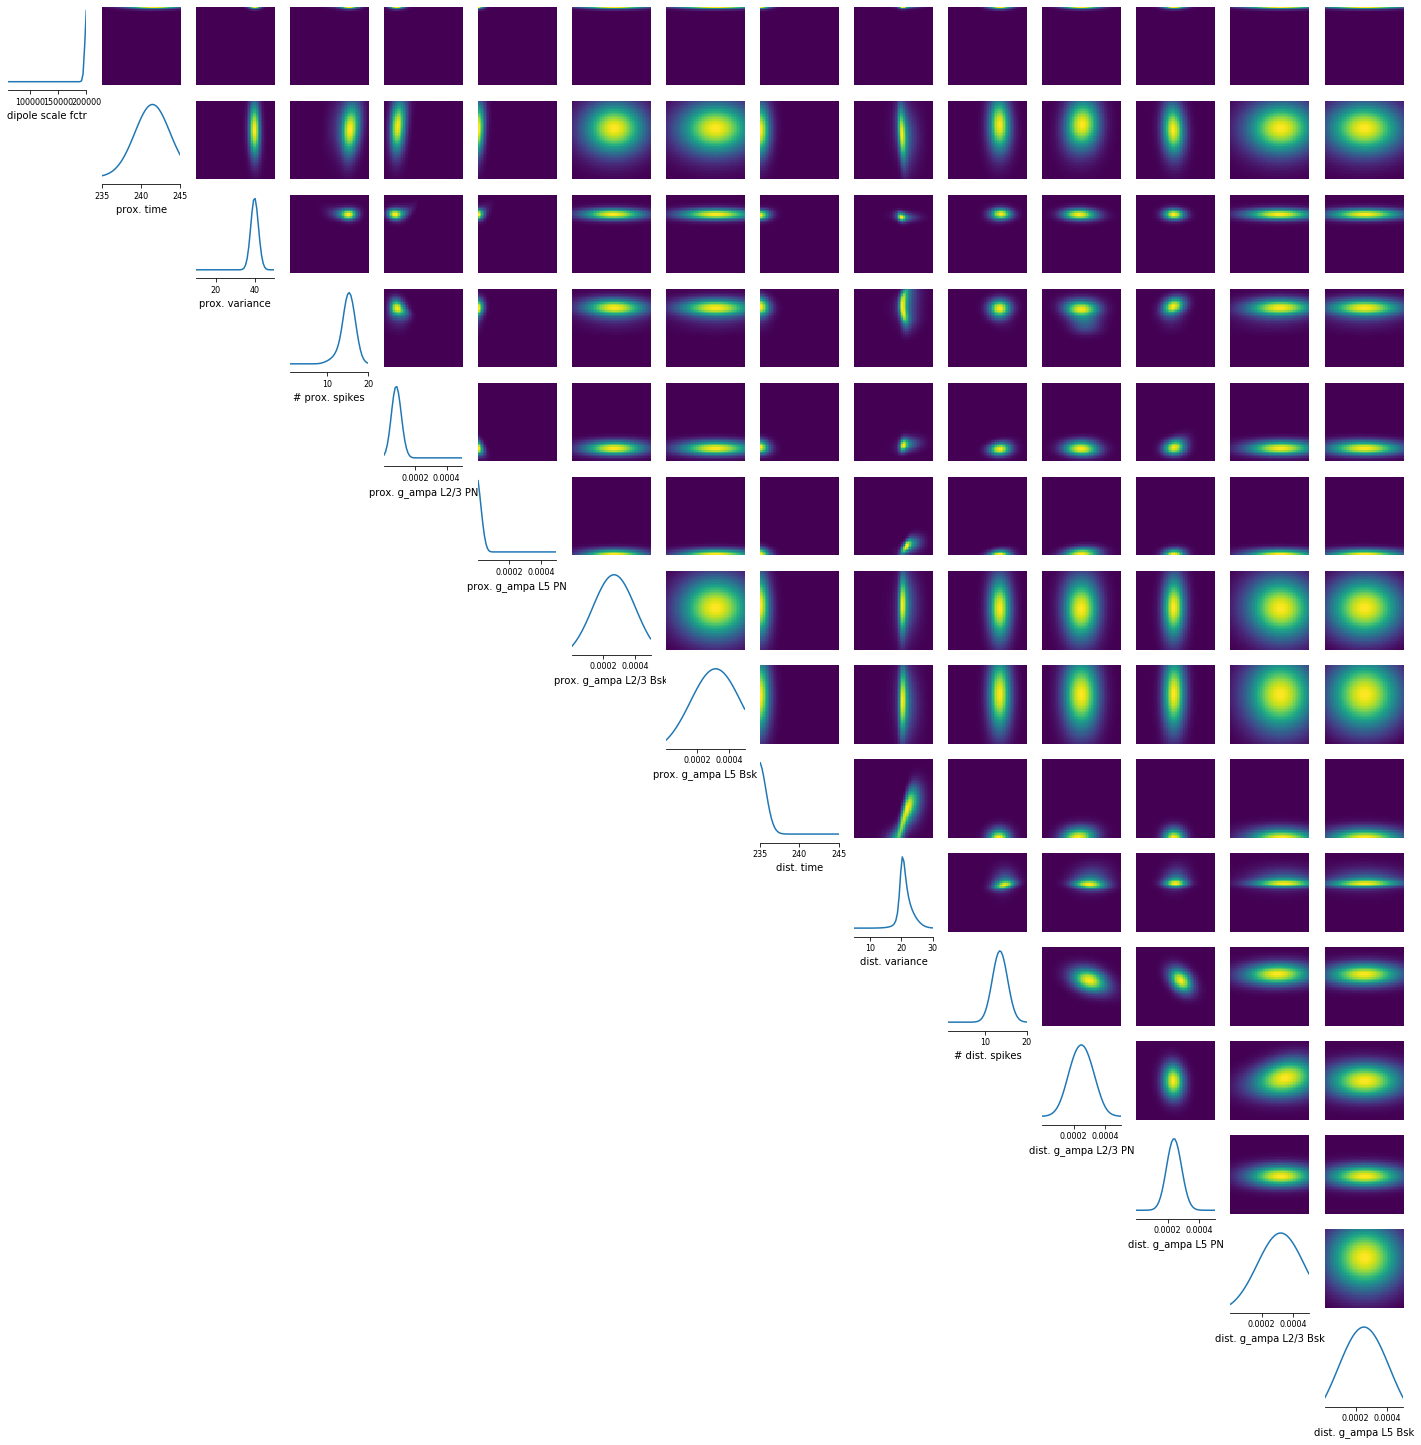

In [11]:
condition = posterior.sample((1,), x=beta23_dpl)
posterior.set_default_x(beta43_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(25,25), labels=param_names, limits=limits, subset=subset)


Condition on 43 yr old dipole

In [1]:
condition = posterior.sample((1,), x=beta43_dpl)
posterior.set_default_x(beta23_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)

NameError: name 'posterior' is not defined

In [ ]:
condition = posterior.sample((1,), x=beta43_dpl)
posterior.set_default_x(beta43_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)